# The PastaStore YAML interface<a id="top"></a>

This notebook shows how [Pastas](https://pastas.readthedocs.io/en/latest/) models can be built from [YAML](https://yaml.org/) files, using [Pastastore](https://pastastore.readthedocs.io/en/latest/).

## Contents

- [Why YAML?](#Why-YAML?)
- [An example YAML file](#An-example-YAML-file)
- [The PastaStore.yaml interface](#The-PastaStore.yaml-interface)
    - [Building model(s) from a YAML file](#Building-model(s)-from-a-YAML-file)
    - [Writing model(s) to a YAML file](#Writing-model(s)-to-a-YAML-file)
    - ["Nearest" options for timeseries](#"Nearest"-options-for-timeseries)
    - [Defaults](#Defaults)
- [More examples](#More-examples)
<hr>

In [1]:
import os
import tempfile
from contextlib import contextmanager
from io import StringIO

import pastastore as pst
import yaml

In [2]:
# create a temporary yaml file that is deleted after usage


@contextmanager
def tempyaml(yaml):
    temp = tempfile.NamedTemporaryFile(delete=False)
    temp.write(yaml.encode("utf-8"))
    temp.close()
    try:
        yield temp.name
    finally:
        os.unlink(temp.name)

## [Why YAML?](#Contents)

YAML, according to the official webpage is _"YAML is a human-friendly data serialization language for all programming languages"_. The file structure is similar to JSON (nested dictionaries) and therefore similar to the storage format for pastas Models, i.e. `.pas`-files. 

So why develop a method for reading/writing pastas models to and from YAML files? The human-readability of the file structure in combination with leveraging tools in pastastore allow users to quickly build pastas Models using a mini-language, without having to explicitly program each line of code. When users are working with a lot of models with different model structures, the YAML files can provide a simple and convenient interface to structure this work, without having to search through lots of lines of code.

Whether it is useful to "program" the models in YAML or in normal Python/pastas code depends on the application or project. This feature was developed to give users an extra option that combines human-readable files with useful tools from the pastastore to quickly develop pastas models. 

## [An example YAML file](#Contents)

A YAML file is text file that uses Python-style indentation to indicate nesting. The following shows the structure of a YAML file for defining a pastas model. 

```yaml
# comments are allowed, this is a pastas Model:

my_first_model:                   # model name
  stressmodels:                   # stressmodels dictionary
    recharge:                     # name of the recharge stressmodel
      stressmodel: RechargeModel  # type of pastas StressModel
      prec: prec1                 # name of precipitation stress, obtained from pastastore
      evap: evap1                 # name of evaporation stress, obtained from pastastore
      recharge: Linear            # pastas recharge type      
      rfunc: Exponential          # rfunc
```

Reading this file converts it into a nested dictionary, as shown below. This dictionary can be used to (re-)construct pastas models, as is shown in the next sections. 

In [3]:
yaml_file = """
# comments are allowed, this is a pastas Model:

my_first_model:                   # model name
  oseries: head_nb1               # head timeseries name, obtained from pastastore
  stressmodels:                   # stressmodels dictionary
    recharge:                     # name of the recharge stressmodel
      class: RechargeModel        # type of pastas StressModel
      prec: prec1                 # name of precipitation stress, obtained from pastastore
      evap: evap1                 # name of evaporation stress, obtained from pastastore
      recharge: Linear            # pastas recharge type
      rfunc: Exponential          # response function
"""

# load the file
d = yaml.load(StringIO(yaml_file), Loader=yaml.Loader)

# view the resulting dictionary
d

{'my_first_model': {'oseries': 'head_nb1',
  'stressmodels': {'recharge': {'class': 'RechargeModel',
    'prec': 'prec1',
    'evap': 'evap1',
    'recharge': 'Linear',
    'rfunc': 'Exponential'}}}}

## [The PastaStore.yaml interface](#Contents)

The logic for reading/writing YAML files is accessed through the `PastaStore.yaml` interface. First we need a PastaStore and fill it with some data to showcase this. Load the example dataset from the PastaStore (included since version 0.8.0 (note, this data is only available if the pastastore repository was cloned and not if it was installed with `pip`).

In [4]:
from pastastore.datasets import example_pastastore

In [5]:
pstore = example_pastastore()
pstore

INFO:hydropandas.io.io_menyanthes:reading menyanthes file /home/david/Github/pastastore/pastastore/../tests/data/MenyanthesTest.men
INFO:hydropandas.io.io_menyanthes:reading oseries -> Obsevation well
INFO:hydropandas.io.io_menyanthes:reading stress -> Evaporation
INFO:hydropandas.io.io_menyanthes:reading stress -> Air Pressure
INFO:hydropandas.io.io_menyanthes:reading stress -> Precipitation
INFO:hydropandas.io.io_menyanthes:reading stress -> Extraction 1
INFO:hydropandas.io.io_menyanthes:reading stress -> Extraction 2
INFO:hydropandas.io.io_menyanthes:reading stress -> Extraction 3
INFO:hydropandas.io.io_menyanthes:reading stress -> Extraction 4


<PastaStore> example: 
 - <DictConnector> 'my_db': 5 oseries, 15 stresses, 0 models

Let's check which oseries are available:

In [6]:
pstore.oseries

,x,y
name,,
oseries1,165000.0,424000.0
oseries2,164000.0,423000.0
oseries3,165554.0,422685.0
head_nb5,200000.0,450000.0
head_mw,85850.0,383362.0


### [Building model(s) from a YAML file](#Contents)

In [7]:
my_first_yaml = """
my_first_model:                   # model name
  oseries: oseries1               # head timeseries name, obtained from pastastore
  stressmodels:                   # stressmodels dictionary
    recharge:                     # name of the recharge stressmodel
      class: RechargeModel        # type of pastas StressModel
      prec: prec1                 # name of precipitation stress, obtained from pastastore
      evap: evap1                 # name of evaporation stress, obtained from pastastore
      recharge: Linear            # pastas recharge type
      rfunc: Exponential          # response function
"""

with tempyaml(my_first_yaml) as f:
    ml = pstore.yaml.load(f)[0]  # returns a list

ml

INFO:pastastore.yaml_interface:Building model 'my_first_model' for oseries 'oseries1'
INFO:pastastore.yaml_interface:| parsing stressmodel: 'recharge'


Model(oseries=oseries1, name=my_first_model, constant=True, noisemodel=True)

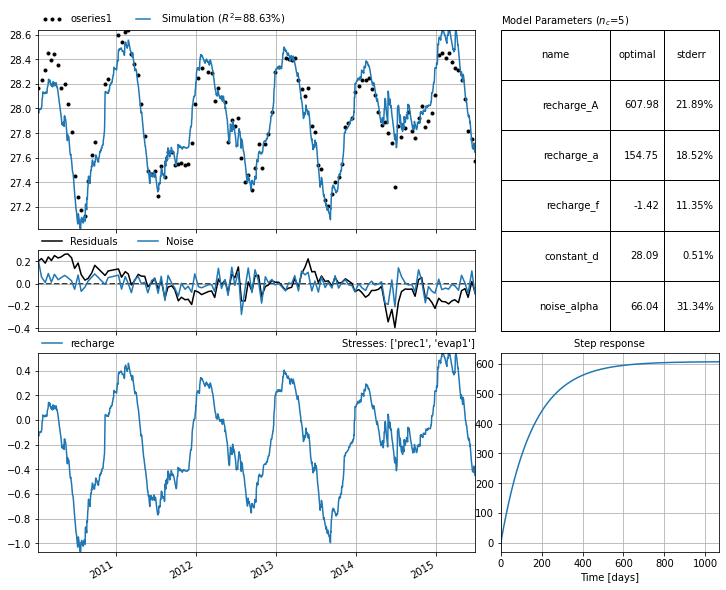

In [8]:
ml.solve(report=False)
ml.plots.results();

A YAML file can contain multiple models

In [9]:
my_multi_model_yaml = """
my_first_model:                   # model name
  oseries: oseries1               # head timeseries name, obtained from pastastore
  stressmodels:                   # stressmodels dictionary
    recharge:                     # name of the recharge stressmodel
      class: RechargeModel        # type of pastas StressModel
      prec: prec1                 # name of precipitation stress, obtained from pastastore
      evap: evap1                 # name of evaporation stress, obtained from pastastore
      recharge: Linear            # pastas recharge type
      rfunc: Exponential          # response function
      
my_second_model:                  # model name
  oseries: oseries1               # head timeseries name, obtained from pastastore
  stressmodels:                   # stressmodels dictionary
    recharge:                     # name of the recharge stressmodel
      class: RechargeModel        # type of pastas StressModel
      prec: prec1                 # name of precipitation stress, obtained from pastastore
      evap: evap1                 # name of evaporation stress, obtained from pastastore
      recharge: FlexModel         # pastas recharge type
      rfunc: Exponential          # response function
"""

In [10]:
with tempyaml(my_multi_model_yaml) as f:
    models = pstore.yaml.load(f)

models

INFO:pastastore.yaml_interface:Building model 'my_first_model' for oseries 'oseries1'
INFO:pastastore.yaml_interface:| parsing stressmodel: 'recharge'
INFO:pastastore.yaml_interface:Building model 'my_second_model' for oseries 'oseries1'
INFO:pastastore.yaml_interface:| parsing stressmodel: 'recharge'


[Model(oseries=oseries1, name=my_first_model, constant=True, noisemodel=True),
 Model(oseries=oseries1, name=my_second_model, constant=True, noisemodel=True)]

Note that these models are not automatically added to the PastaStore. They are only created. To store them use `PastaStore.add_model`.

In [11]:
for ml in models:
    pstore.add_model(ml)

In [12]:
pstore

<PastaStore> example: 
 - <DictConnector> 'my_db': 5 oseries, 15 stresses, 2 models

### [Writing model(s) to a YAML file](#Contents)

Writing an existing model to a YAML file is done with `PastaStore.yaml.export_model()`. The resulting YAML file contains a lot more information as all model information is stored in the file, similar to saving a model as `.pas`-file with `ml.to_file()`. It can be useful to take a look at this file as a template for writing your own YAML files. 

In [13]:
pstore.yaml.export_model(ml)

The YAML file can be simplified with the `minimal_yaml` keyword argument.

<div class="alert alert-block alert-info">
<b>Warning:</b> Using the `minimal_yaml=True` option can lead to a different model than the one being exported as certain important model settings might have been removed in the resulting YAML file. Use with care!
</div>

In [14]:
ml.name = ml.name + "_minimal"
pstore.yaml.export_model(ml, minimal_yaml=True)

Additionally, the `use_nearest` option fills in `"nearest <n> <kind>"` instead of the names of the timeseries, filling in `<n>` and `<kind>` where possible. This option is only used when `minimal_yaml=True`.

<div class="alert alert-block alert-info">
<b>Warning:</b> This option does not check whether the timeseries are actually nearest, it simply fills in "nearest" for all stresses and fills in "kind" where possible.
</div>

In [15]:
ml.name = ml.name + "_nearest"
pstore.yaml.export_model(ml, minimal_yaml=True, use_nearest=True)

The models can als be written to a single YAML-file using `PastaStore.yaml.export_models()`. The `split=False` kwarg forces all models to be written to the same file.

In [16]:
pstore.yaml.export_models(models=models, split=False)

### "Nearest" options for timeseries

The YAML file format introduces some useful features that leverage useful tools in PastaStore. Instead of explicitly defining the timeseries to use for a particular stressmodel, there is a `nearest` option. Note that this requires the metadata of the timeseries in the PastaStore to be properly defined, with `x` and `y` coordinates for all timeseries.

First let's revisit the first example YAML file, but this time use the "nearest" option to select the precipitation and evaporation timeseries. After nearest the `kind` identifier is supplied to tell the PastaStore which types of stresses to consider when looking for the nearest one.

In [17]:
nearest_yaml = """
my_first_model:                   # model name
  oseries: oseries1               # head timeseries name, obtained from pastastore
  stressmodels:                   # stressmodels dictionary
    recharge:                     # name of the recharge stressmodel
      class: RechargeModel        # type of pastas StressModel
      prec: nearest prec          # nearest stress with kind="prec" obtained from pastastore
      evap: nearest evap          # nearest stress with kind="evap" obtained from pastastore
      recharge: Linear            # pastas recharge type
      rfunc: Exponential          # response function
"""

with tempyaml(nearest_yaml) as f:
    ml = pstore.yaml.load(f)[0]  # returns a list

ml

INFO:pastastore.yaml_interface:Building model 'my_first_model' for oseries 'oseries1'
INFO:pastastore.yaml_interface:| parsing stressmodel: 'recharge'
INFO:pastastore.yaml_interface:  | using nearest stress with kind='prec': 'prec1'
INFO:pastastore.yaml_interface:  | using nearest stress with kind='evap': 'evap1'


Model(oseries=oseries1, name=my_first_model, constant=True, noisemodel=True)

The nearest option is parsed depending on the type of stressmodel. Generally, the form is `nearest <kind>`, but for the RechargeModel, just providing `nearest` will assume the kind is `kind="prec"` or `kind="evap"`.

For WellModel, the number of nearest stresses can be passed as well, e.g. `nearest <n> <kind>`.

The following examples illustrate this:

In [18]:
full_nearest_yaml = """
nearest_model_1:                  # model name
  oseries: head_nb5               # head timeseries name, obtained from pastastore
  stressmodels:                   # stressmodels dictionary
    recharge:                     # name of the recharge stressmodel
      class: RechargeModel        # type of pastas stressmodel
      prec: nearest               # nearest stress with kind="prec" obtained from pastastore
      evap: nearest evap          # nearest stress with kind="evap" obtained from pastastore
      recharge: Linear            # pastas recharge type
      rfunc: Exponential          # response function
    river:                        # name for river stressmodel
      class: StressModel          # type of pastas stressmodel
      stress: nearest riv         # nearest stress with kind="riv" obtained from pastastore
      rfunc: One                  # response function
      
      
nearest_model_2:
  oseries: head_mw
  stressmodels:                   
    recharge:                     
      class: RechargeModel  
      prec: nearest               
      evap: nearest evap          
      recharge: Linear            
      rfunc: Exponential          
    wells:                        
      class: WellModel    
      stress: nearest 2 well         
      rfunc: HantushWellModel
      up: False
"""

In [19]:
with tempyaml(full_nearest_yaml) as f:
    models = pstore.yaml.load(f)  # returns a list

INFO:pastastore.yaml_interface:Building model 'nearest_model_1' for oseries 'head_nb5'
INFO:pastastore.yaml_interface:| parsing stressmodel: 'recharge'
INFO:pastastore.yaml_interface:  | using nearest stress with kind='prec': 'prec_nb5'
INFO:pastastore.yaml_interface:  | using nearest stress with kind='evap': 'evap_nb5'
INFO:pastastore.yaml_interface:| parsing stressmodel: 'river'
INFO:pastastore.yaml_interface:  | using nearest stress with kind='riv': riv_nb5
INFO:pastastore.yaml_interface:Building model 'nearest_model_2' for oseries 'head_mw'
INFO:pastastore.yaml_interface:| parsing stressmodel: 'recharge'
INFO:pastastore.yaml_interface:  | using nearest stress with kind='prec': 'prec_mw'
INFO:pastastore.yaml_interface:  | using nearest stress with kind='evap': 'evap_mw'
INFO:pastastore.yaml_interface:| parsing stressmodel: 'wells'
INFO:pastastore.yaml_interface:  | using 2 nearest stress(es) with kind='well': ['extraction_2' 'extraction_3']


In [20]:
ml = models[0]

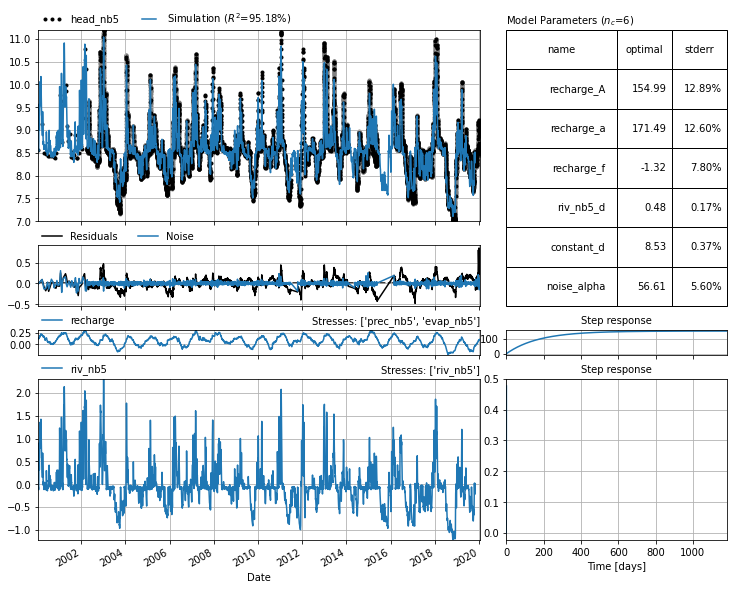

In [21]:
ml.solve(report=False)
ml.plots.results();

### [Defaults](#Contents)

The Pastastore YAML interface adds some additional defaults as compared to pastas. These defaults allow the user to only provide only certain information in a YAML file in order to construct a model. These defaults are determined based on commonly used options. It should be noted that these defaults are not necessarily appropriate in all situations, and it is highly recommended to try different models with different options. These defaults are therefore implemented to facilitate building models, but should not be deemed holy.

The YAML interface mostly uses the Pastas defaults, but adds some additional logic for stressmodels. When default settings implemented in the YAML interface are implemented, this is logged to the console.

- **RechargeModel**:
    - If stressmodel name is one of "rch", "rech", "recharge", or "rechargemodel", assume stressmodel type is RechargeModel.
    - If no "prec" or "evap" keys are provided for RechargeModel, use the "nearest" option. 
    - Default rfunc for RechargeModel is "Exponential".
    - prec: accepts `nearest` or `nearest <kind>`, if only `nearest` is provided, stresses in PastaStore must be labelled with kind="prec"
    - evap: accepts `nearest` or `nearest <kind>`, if only `nearest` is provided, stresses in PastaStore must be labelled with kind="evap"
- **StressModel**:
    - If no "stressmodel" key is contained in dictionary, assume stressmodel type is StressModel
    - Default rfunc for StressModel is "Gamma".
    - stress: accepts `nearest` or `nearest <kind>`, if only "nearest" is provided, uses whichever stress is nearest.
- **WellModel**:
    - Default rfunc for WellModel is "HantushWellModel".
    - If "up" is not provided, assume up=False, i.e. positive discharge timeseries indicates pumping.
    - stress: accepts `nearest`, `nearest <n>` and `nearest <n> <kind>`, where n is the number of wells to add. If kind is not passed, stresses must be labelled with kind="well" in PastaStore. If n is not passed, assumes n=1.

This is the shortest possible YAML file for a model with recharge, that makes use of all of the defaults for RechargeModel:

In [22]:
minimal_yaml = """
ml_minimal:
  oseries: oseries2
  stressmodels:
    recharge:
"""

Note that the YAML load method recognizes the stressmodel name "recharge" and assumes the type of stress model should be RechargeModel. Additionally note the defaults as no other information is provided.
- prec --> nearest stress with kind="prec"
- evap --> nearest stress with kind="evap"
- recharge --> Linear
- rfunc --> Exponential

In [23]:
with tempyaml(minimal_yaml) as f:
    ml = pstore.yaml.load(f)[0]  # returns a list

INFO:pastastore.yaml_interface:Building model 'ml_minimal' for oseries 'oseries2'
INFO:pastastore.yaml_interface:| parsing stressmodel: 'recharge'
INFO:pastastore.yaml_interface:| assuming RechargeModel based on stressmodel name.
INFO:pastastore.yaml_interface:  | using nearest stress with kind='prec': 'prec2'
INFO:pastastore.yaml_interface:  | using nearest stress with kind='evap': 'evap2'
INFO:pastastore.yaml_interface:  | no 'rfunc' provided, using 'Exponential'
INFO:pastastore.yaml_interface:  | no 'recharge' type provided, using 'Linear'


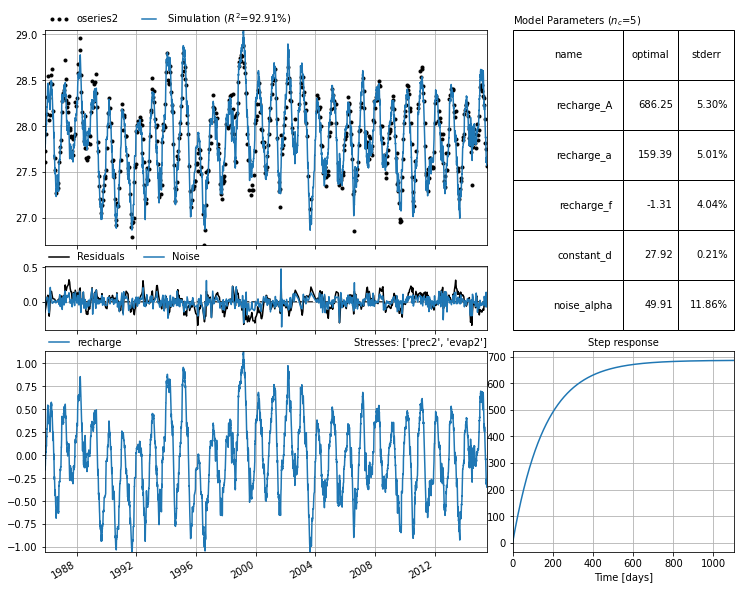

In [24]:
ml.solve(report=False)
ml.plots.results();

## [More examples](#Contents)

In [25]:
yaml_examples = """
# Pastas YAML example file
# ------------------------

# 1. Explicitly provide oseries, stresses names rfunc and
#    recharge type.

ml_explicit:
  settings:
    freq: D
  oseries: oseries1
  stressmodels:
    recharge:
      class: RechargeModel
      prec: prec1
      evap: evap1
      rfunc: Exponential
      recharge: Linear

# 2. Provide oseries, stresses names but use defaults for
#    other settings:

ml_stresses:
  oseries: oseries1
  stressmodels:
    recharge:
      prec: prec1
      evap: evap1

# 3. Use "nearest" to obtain nearest precipitation and evaporation
#    timeseries. Requires x, y data to be present in oseries and
#    stresses metadata.

ml_nearest:
  oseries: oseries1
  stressmodels:
    recharge:
      prec: nearest prec
      evap: nearest
"""

In [26]:
with tempyaml(yaml_examples) as f:
    models = pstore.yaml.load(f)  # returns a list

INFO:pastastore.yaml_interface:Building model 'ml_explicit' for oseries 'oseries1'
INFO:pastastore.yaml_interface:| parsing stressmodel: 'recharge'
INFO:pastastore.yaml_interface:Building model 'ml_stresses' for oseries 'oseries1'
INFO:pastastore.yaml_interface:| parsing stressmodel: 'recharge'
INFO:pastastore.yaml_interface:| assuming RechargeModel based on stressmodel name.
INFO:pastastore.yaml_interface:  | no 'rfunc' provided, using 'Exponential'
INFO:pastastore.yaml_interface:  | no 'recharge' type provided, using 'Linear'
INFO:pastastore.yaml_interface:Building model 'ml_nearest' for oseries 'oseries1'
INFO:pastastore.yaml_interface:| parsing stressmodel: 'recharge'
INFO:pastastore.yaml_interface:| assuming RechargeModel based on stressmodel name.
INFO:pastastore.yaml_interface:  | using nearest stress with kind='prec': 'prec1'
INFO:pastastore.yaml_interface:  | using nearest stress with kind='evap': 'evap1'
INFO:pastastore.yaml_interface:  | no 'rfunc' provided, using 'Exponenti

The first and last models are identical, except for the name obviously. The second one is also the same, but that is not shown below.

In [27]:
pst.util.compare_models(models[0], models[-1], detailed_comparison=True)

,model 0,model 1,comparison
name:,ml_explicit,ml_nearest,False
- settings: tmin,None,None,True
- settings: tmax,None,None,True
- settings: freq,D,D,True
- settings: warmup,3650 days 00:00:00,3650 days 00:00:00,True
- settings: time_offset,0 days 00:00:00,0 days 00:00:00,True
- settings: noise,True,True,True
- settings: solver,None,None,True
- settings: fit_constant,True,True,True
oseries: series_original,True,True,True


Clean up the written YAML files.

In [28]:
for f in [fi for fi in os.listdir(".") if fi.endswith(".yaml")]:
    os.remove(f)